In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
import numpy as np
import os
import shutil
import subprocess
import multiprocessing
import matplotlib.pyplot as plt
import gstools as gs
from mpl_toolkits.basemap import Basemap
from pathlib import Path

KM_PER_DEG = 111.195

def read_model3d(dname):
    ## Read original 3D model
    block_x = np.loadtxt('%s/block_x' % dname)[2:]
    block_y = np.loadtxt('%s/block_y' % dname)[2:]
    block_z = np.loadtxt('%s/block_z' % dname)[2:]
    dvsv = np.loadtxt('%s/dvsv' % dname)[2:]
    delta_d = 0.5
    return block_x, block_y, block_z, dvsv, delta_d

def perturb_model3d_uncorrelated_3d(x, y, z, dvsv, gsmodel_kw, seed):
    np.random.seed(seed)
    return dvsv*np.random.normal(1,delta,dvsv.shape)

def perturb_model3d_gaussian_3d(x, y, z, dvsv, gsmodel_kw, seed):
    model = gs.Gaussian(dim=3, **gsmodel_kw)
    srf = gs.SRF(model, seed=seed)
    scale = srf.structured([x, y, z]) + 1
    return dvsv * scale

def perturb_model3d_exponential_3d(x, y, z, dvsv, gsmodel_kw, seed):
    model = gs.Exponential(dim=3, **gsmodel_kw)
    srf = gs.SRF(model, seed=seed)
    scale = srf.structured([x, y, z]) + 1
    return dvsv * scale

def prepare_wdir_for_perturbed_model(pp, perturb_model3d, gsmodel_kw, out_dname='.'):
    ## random seed
    seed = pp+1
    ## Directory preparation
    src_dname = '/home/158/tp1732/lv88/MTI3D/ses3d_r07_b'
    dst_dname = os.path.join(out_dname, 'MODEL%03d' % (pp+1))
    if not os.path.exists(dst_dname): 
        os.makedirs(dst_dname)
    else: return
    print ('Preparing mesh for %s ...' % dst_dname)
    dst_dname = os.path.abspath(dst_dname)
    ## Copy INPUT
    if not os.path.exists('%s/INPUT' % dst_dname): os.mkdir('%s/INPUT' % dst_dname)
    for fname in ['setup', 'relax', 'source.txt', 'stations.txt', 'stf']:
        shutil.copy('%s/INPUT/%s' % (src_dname, fname), '%s/INPUT/%s' % (dst_dname, fname))
    ## Copy MAIN
    if not os.path.exists('%s/MAIN' % dst_dname): os.mkdir('%s/MAIN' % dst_dname)
    for fname in ['run_ses3d.pbs', 'ses3d']:
        shutil.copy('%s/MAIN/%s' % (src_dname, fname), 
                    '%s/MAIN/%s' % (dst_dname, fname))
    ## Copy and Create MODELS
    if not os.path.exists('%s/MODELS/MAIN' % dst_dname): 
        os.makedirs('%s/MODELS/MAIN' % dst_dname)
    for fname in ['run_gm.sh', 'add_perturbation', 'gm']:
        shutil.copy('%s/MODELS/MAIN/%s' % (src_dname, fname), 
                    '%s/MODELS/MAIN/%s' % (dst_dname, fname))
    if not os.path.exists('%s/MODELS/MODELS_3D' % dst_dname): 
        os.makedirs('%s/MODELS/MODELS_3D' % dst_dname)
    if not os.path.exists('%s/MODELS/MODELS' % dst_dname): 
        os.makedirs('%s/MODELS/MODELS' % dst_dname)
    ## Create DATA/COORDINATES
    if not os.path.exists('%s/DATA/COORDINATES' % dst_dname): 
        os.makedirs('%s/DATA/COORDINATES' % dst_dname)
    ## Copy block files
    for fname in 'xyz': 
        shutil.copyfile('%s/MODELS/MODELS_3D/block_%s' % (src_dname, fname), 
                        '%s/MODELS/MODELS_3D/block_%s' % (dst_dname, fname))
    ## Read original model
    block_x, block_y, block_z, dvsv, delta_d = read_model3d('%s/MODELS/MODELS_3D' % src_dname)
    x = 0.5*(block_x[1:] + block_x[:-1])
    y = 0.5*(block_y[1:] + block_y[:-1])
    z = 0.5*(block_z[1:] + block_z[:-1])
    dvsv = dvsv.reshape((len(block_x)-1, len(block_y)-1, len(block_z)-1))
    ## Produce model pertubation
    dvsv = perturb_model3d(x, y, z, dvsv, gsmodel_kw, seed)
    ## Conversion from vs model to vp and density models
    dvsv = dvsv.flatten()
    dvp = 1.7 * dvsv
    drho = 1.7 + 0.34 * dvsv
    ## Write output model
    dname = '%s/MODELS/MODELS_3D' % dst_dname
    with open('%s/dvsv' % dname, 'w') as fid:
        fid.write('1\n%d\n' % len(dvsv))
        for v in dvsv: fid.write('%.5f\n' % v)
    with open('%s/dvsh' % dname, 'w') as fid:
        fid.write('1\n%d\n' % len(dvsv))
        for v in dvsv: fid.write('%.5f\n' % v)
    with open('%s/dvp' % dname , 'w') as fid:
        fid.write('1\n%d\n' % len(dvp))
        for v in dvp: fid.write('%.5f\n' % v)
    with open('%s/drho' % dname, 'w') as fid:
        fid.write('1\n%d\n' % len(drho))
        for v in drho: fid.write('%.5f\n' % v)
    ## Submmit job to run mesher
    wdir = '%s/MODELS/MAIN' % dst_dname
    print ( '   > generating mesh ...')
    cmd = './run_gm.sh'
    out = subprocess.run(cmd,stdout=subprocess.PIPE,text=True,shell=True,cwd=wdir)

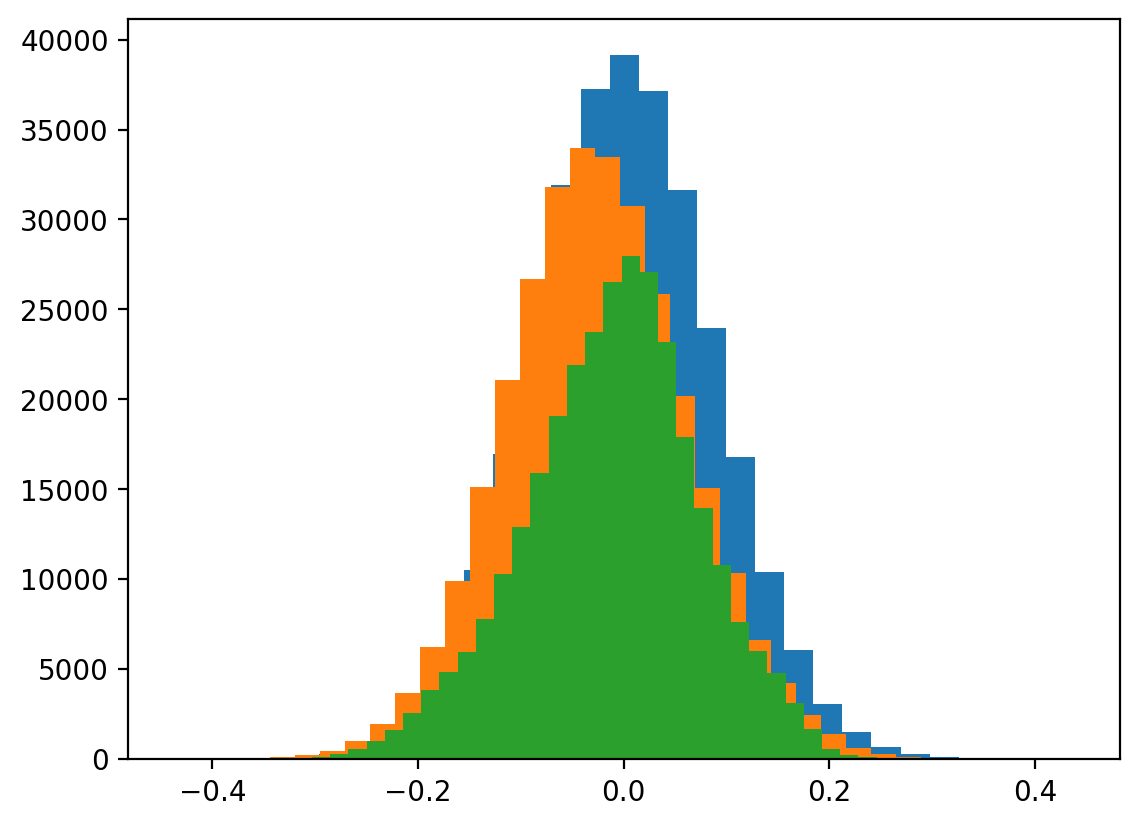

In [13]:
## model
delta = 0.02
gsmodel_kw = {'len_scale': (2, 2, 50), 'var':delta**2}
## model 3D
src_dname = '/home/158/tp1732/lv88/MTI3D/ses3d_r07_b'
block_x, block_y, block_z, dvsv, delta_d = read_model3d('%s/MODELS/MODELS_3D' % src_dname)
x = 0.5*(block_x[1:] + block_x[:-1])
y = 0.5*(block_y[1:] + block_y[:-1])
z = 0.5*(block_z[1:] + block_z[:-1])
dvsv = dvsv.reshape((len(block_x)-1, len(block_y)-1, len(block_z)-1))
## Produce model pertubation
fig, ax = plt.subplots()
for perturb_model3d in [perturb_model3d_uncorrelated_3d,
                        perturb_model3d_exponential_3d,
                        perturb_model3d_gaussian_3d]:
    dvsv_new = perturb_model3d(x, y, z, dvsv, gsmodel_kw, 1)
    ax.hist((dvsv_new-dvsv).ravel(), bins=31)
plt.show()

In [4]:
from functools import partial

kw0 = {'vmin': 2.6,'vmax': 5.6,'levels': np.linspace(2.6, 5.6, 11)}
kw1 = {'vmin': -.2,'vmax': .2,'levels': np.linspace(-.2, .2, 11),'cmap': 'bwr'}
coast_kw0 = {'color':'khaki', 'linewidth':.5}
coast_kw1 = {'color':'k', 'linewidth':.5}
def plot_model_3d(dname):
    ## Read Earth's model from directory
    x = np.loadtxt('%s/block_x' % dname)[2:]
    x = 90-.5*(x[1:]+x[:-1])
    y = np.loadtxt('%s/block_y' % dname)[2:]
    y = .5*(y[1:]+y[:-1])
    z = np.loadtxt('%s/block_z' % dname)[2:]
    z = 6371-.5*(z[1:]+z[:-1])
    nbx = len(x)
    nby = len(y)
    nbz = len(z)
    idx,idy,idz = np.mgrid[0:nbx,0:nby,0:nbz]
    X = x[idx]
    Y = y[idy]
    Z = z[idz]
    data0 = np.loadtxt('%s/dvsv' % 'MODELS/MODELS_3D')[2:].reshape((nbx, nby, nbz))
    data = np.loadtxt('%s/dvsv' % dname)[2:].reshape((nbx, nby, nbz))

    def view_block(ax, data, kw):
        # Plot contour surfaces
        _ = ax.contourf(X[:, :, -1], Y[:, :, -1], data[:, :, -1], zdir='z', offset=0, **kw)
        _ = ax.contourf(data[0, :, :], Y[0, :, :], Z[0, :, :], zdir='x', offset=X.max(), **kw)
        C = ax.contourf(X[:, 0, :], data[:, 0, :], Z[:, 0, :], zdir='y', offset=Y.min(), **kw)
        # --
        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()
        zmin, zmax = z.min(), z.max()

        # Set limits of the plot from coord limits
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmax, zmin])
        # Plot edges
        edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
        ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.zaxis.pos = 'right'

        # Set labels and zticks
        ax.set(xlabel='lat (deg)', ylabel='lon (deg)', zlabel='dep (km)', zticks=np.linspace(0,300,4))

        # Set zoom and angle view
        ax.view_init(40, -30, 0)
        ax.set_box_aspect(None, zoom=0.9)
    
    def view_map(ax, data, contourf_kw, coast_kw):
        # ####### LOCATION MAP
        bm = Basemap(projection='merc',resolution='i',ax=ax,
                     llcrnrlat=36,urcrnrlat=44.4,llcrnrlon=123,urcrnrlon=132)
        yy, xx = np.meshgrid(y, x)
        bm.contourf(yy, xx, data[:, :, -5], latlon=True, **contourf_kw)
        bm.drawcoastlines(**coast_kw)
        bm.drawcountries(**coast_kw)
        bm.drawparallels(range(33,46,2),labels=(0,1,0,0),linewidth=.2,dashes=(3,1))
        bm.drawmeridians(range(122,133,3),labels=(0,0,0,1),linewidth=.2,dashes=(3,1))
        stla = np.loadtxt('INPUT/stations.txt', usecols=[1])
        stlo = np.loadtxt('INPUT/stations.txt', usecols=[2])
        xx,yy = bm(stlo,stla)
        ax.plot(xx,yy,'v', c='r')
        xx, yy = bm(129.049, 41.320)
        ax.plot(xx,yy,'*', c='yellow', ms=10)

    # Create a figure with 3D ax
    fig = plt.figure(figsize=(8., 6))
    ax = fig.add_subplot(231, projection='3d')
    view_block(ax, data0, kw0)
    ax = fig.add_subplot(232, projection='3d')
    view_block(ax, data-data0, kw1)
    ax = fig.add_subplot(233, projection='3d')
    view_block(ax, data, kw0)
    ax = fig.add_subplot(234)
    view_map(ax, data0, kw0, coast_kw0)
    ax = fig.add_subplot(235)
    view_map(ax, data-data0, kw1, coast_kw1)
    ax = fig.add_subplot(236)
    view_map(ax, data, kw0, coast_kw0)
    
    # Colorbar
    # fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='S-wave velocity (km/s)')

    # Show Figure
    fig.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    ## Number of perturbations
    nperturbs = 49

    ## Perturbation function
    # perturb_fn = perturb_model3d_uncorrelated_3d
    perturb_fn = perturb_model3d_gaussian_3d
    # perturb_fn = perturb_model3d_exponential_3d
    
    for delta in [0.01, 0.02, 0.03]:
        ## Prepare working directory
        work_path = Path('PERTURB_MODELS')
        out_dir = work_path / perturb_fn.__name__[16:].upper() / ('%d' % (delta*100))
        ## Perturbation parameters
        gsmodel_kw = {'len_scale': (2, 2, 50), 'var':delta**2}
        ## Execute actual work
        # prepare_wdir_for_perturbed_model(0, perturb_fn, gsmodel_kw, out_dir)
        ## Parallel execution
        kw = {'perturb_model3d':perturb_fn, 'gsmodel_kw':gsmodel_kw, 'out_dname':out_dir}
        partial_func = partial(prepare_wdir_for_perturbed_model, **kw)
        with multiprocessing.Pool(7) as pool:
            pool.map(partial_func, range(nperturbs))
        ## Plot model for visualisation
        plot_model_3d(out_dir/('MODEL%03d/MODELS/MODELS_3D' % 1))

Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL031 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL029 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL033 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL035 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL037 ...

Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL041 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL039 ...




   > generating mesh ...
   > generating mesh ...
   > generating mesh ...
   > generating mesh ...
   > generating mesh ...
   > generating mesh ...   > generating mesh ...

Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL038 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL032 ...Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL040 ...


Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL034 ...
Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL030 ...
Preparing mesh for PERTURB_MODELS/GAUSSIAN_3D/4/MODEL042 ...
Preparing mesh for PERTURB_MODEL